In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing as mp
from numba import jit
import time
from tqdm import tqdm

In [2]:
X_RES = 5000
X_MIN = -2
X_MAX = 0.5
Y_RES = 5000
Y_MIN = -1.25
Y_MAX = 1.25

I = 50
T = 2

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Madlebrot figure
def make_plot(M, cmap='hot', save=False, filename='mandelbrot.png'):
    plt.figure(figsize=(16, 16))
    plt.imshow(M, cmap=cmap, aspect='equal', extent=[X_MIN, X_MAX, Y_MIN, Y_MAX])

    if save:
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)

## Navie (loops) solution

In [4]:
def mandelbrot_naive(c, M, I=I, T=T):
    if c.shape != M.shape:
        raise ValueError('c and M must have the same shape')
    
    for x in range(c.shape[0]):
        for y in range(c.shape[1]):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + c[x, y]
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1


re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES) * 1j

c = re + im[:, np.newaxis]
M = np.zeros((X_RES, Y_RES))

time_start = time.time()
mandelbrot_naive(c, M)
time_delta_naive = time.time() - time_start

print(f'Elapsed time: {time_delta_naive:.2f} s')

Elapsed time: 122.38 s


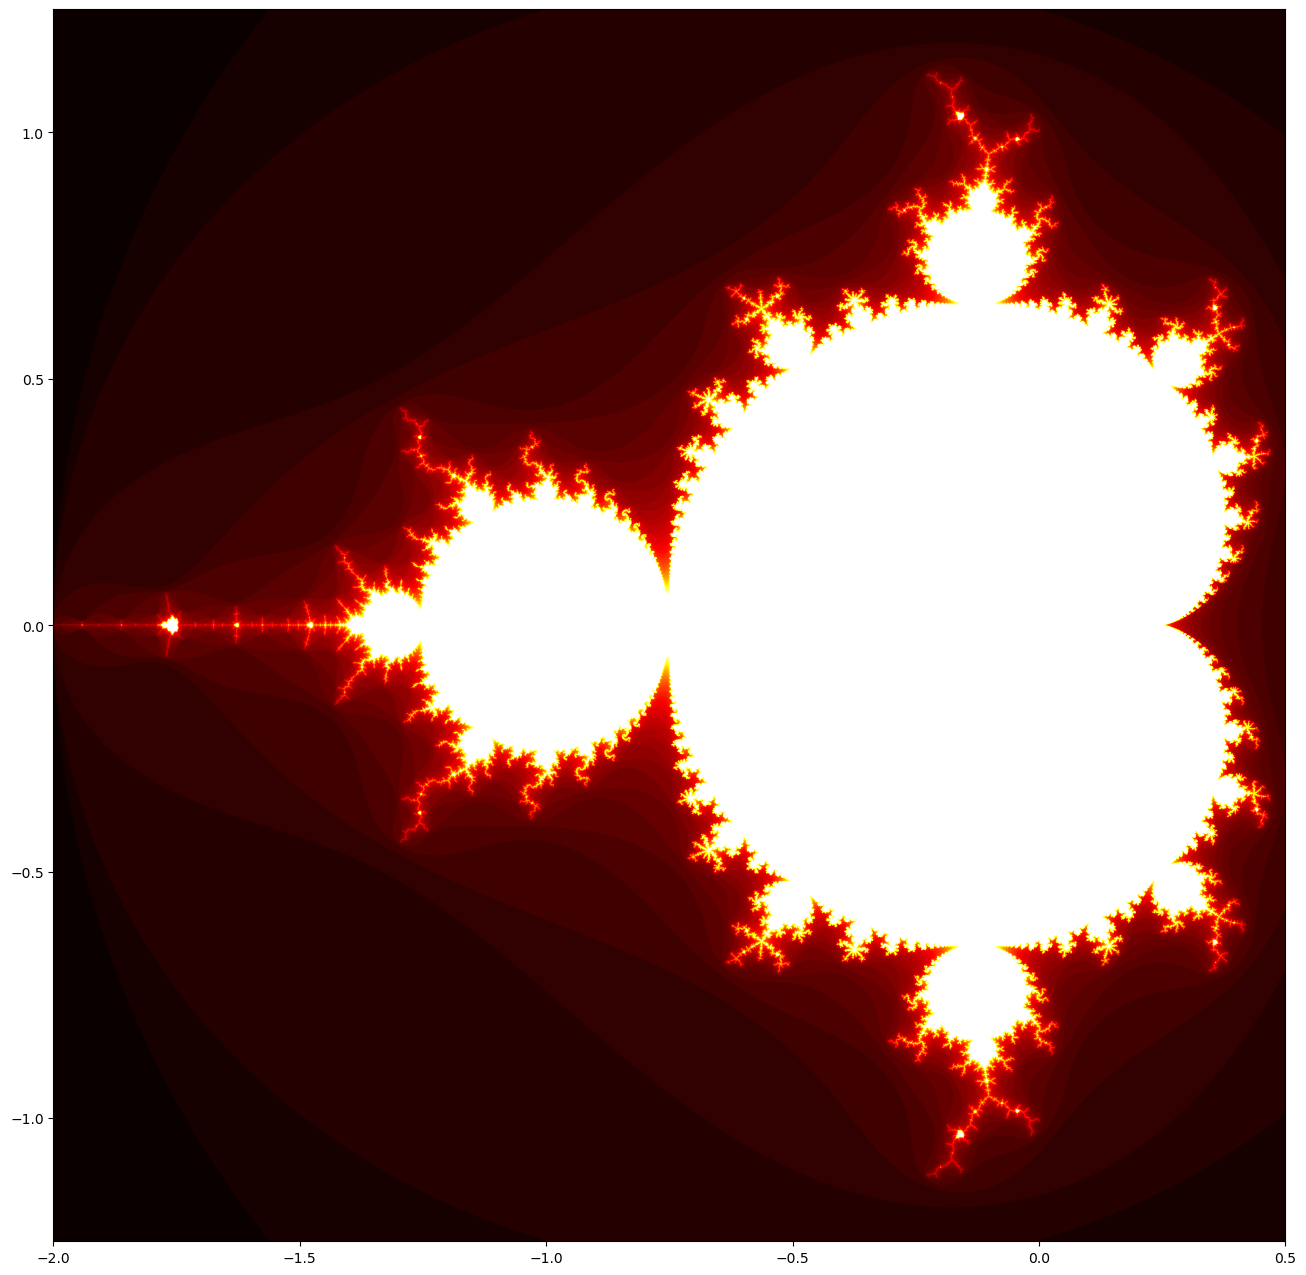

In [5]:
make_plot(M, cmap='hot')

## Numpy (vectorized) solution

In [6]:
def mandelbrot_vectorized(c, M, I=I, T=T):
    if c.shape != M.shape:
        raise ValueError('c and M must have the same shape')
    
    z = np.zeros_like(c)
    for i in range(I):
        z = z**2 + c
        mask = T <= abs(z)
        M[mask] = i / I
        
    M[M == 0] = 1


re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES) * 1j

c = re + im[:, np.newaxis]
M = np.zeros((X_RES, Y_RES))

time_start = time.time()
mandelbrot_vectorized(c, M)
time_delta_vectorized = time.time() - time_start

print(f'Elapsed time: {time_delta_vectorized:.2f} s')

Elapsed time: 13.17 s


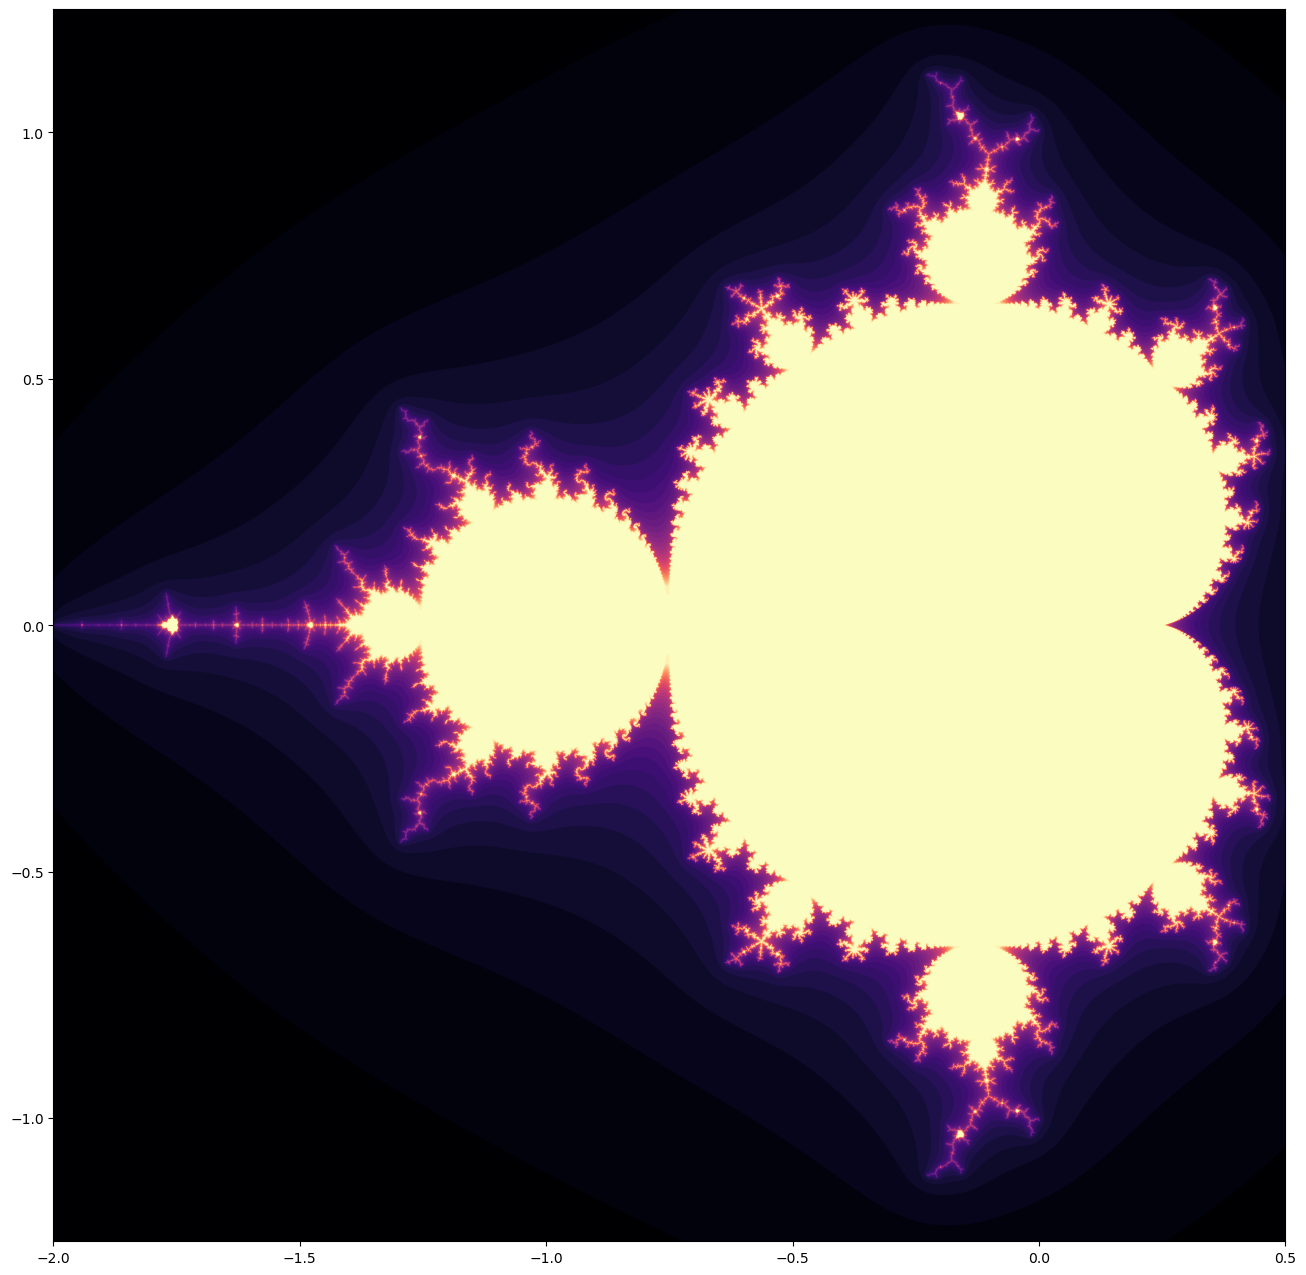

In [7]:
make_plot(M, cmap='magma')

## Numba (optimized) solution

In [8]:
@jit(nopython=True)
def mandelbrot_numba(c, M, I=I, T=T):
    if c.shape != M.shape:
        raise ValueError('c and M must have the same shape')
    
    for x in range(X_RES):
        for y in range(Y_RES):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + c[x, y]
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1


re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES) * 1j

c = re + im[:, np.newaxis]
M = np.zeros((X_RES, Y_RES))
 
time_start = time.time()
mandelbrot_numba(c, M)
time_delta_numba = time.time() - time_start

print(f'Elapsed time: {time_delta_numba:.2f} s')

Elapsed time: 2.86 s


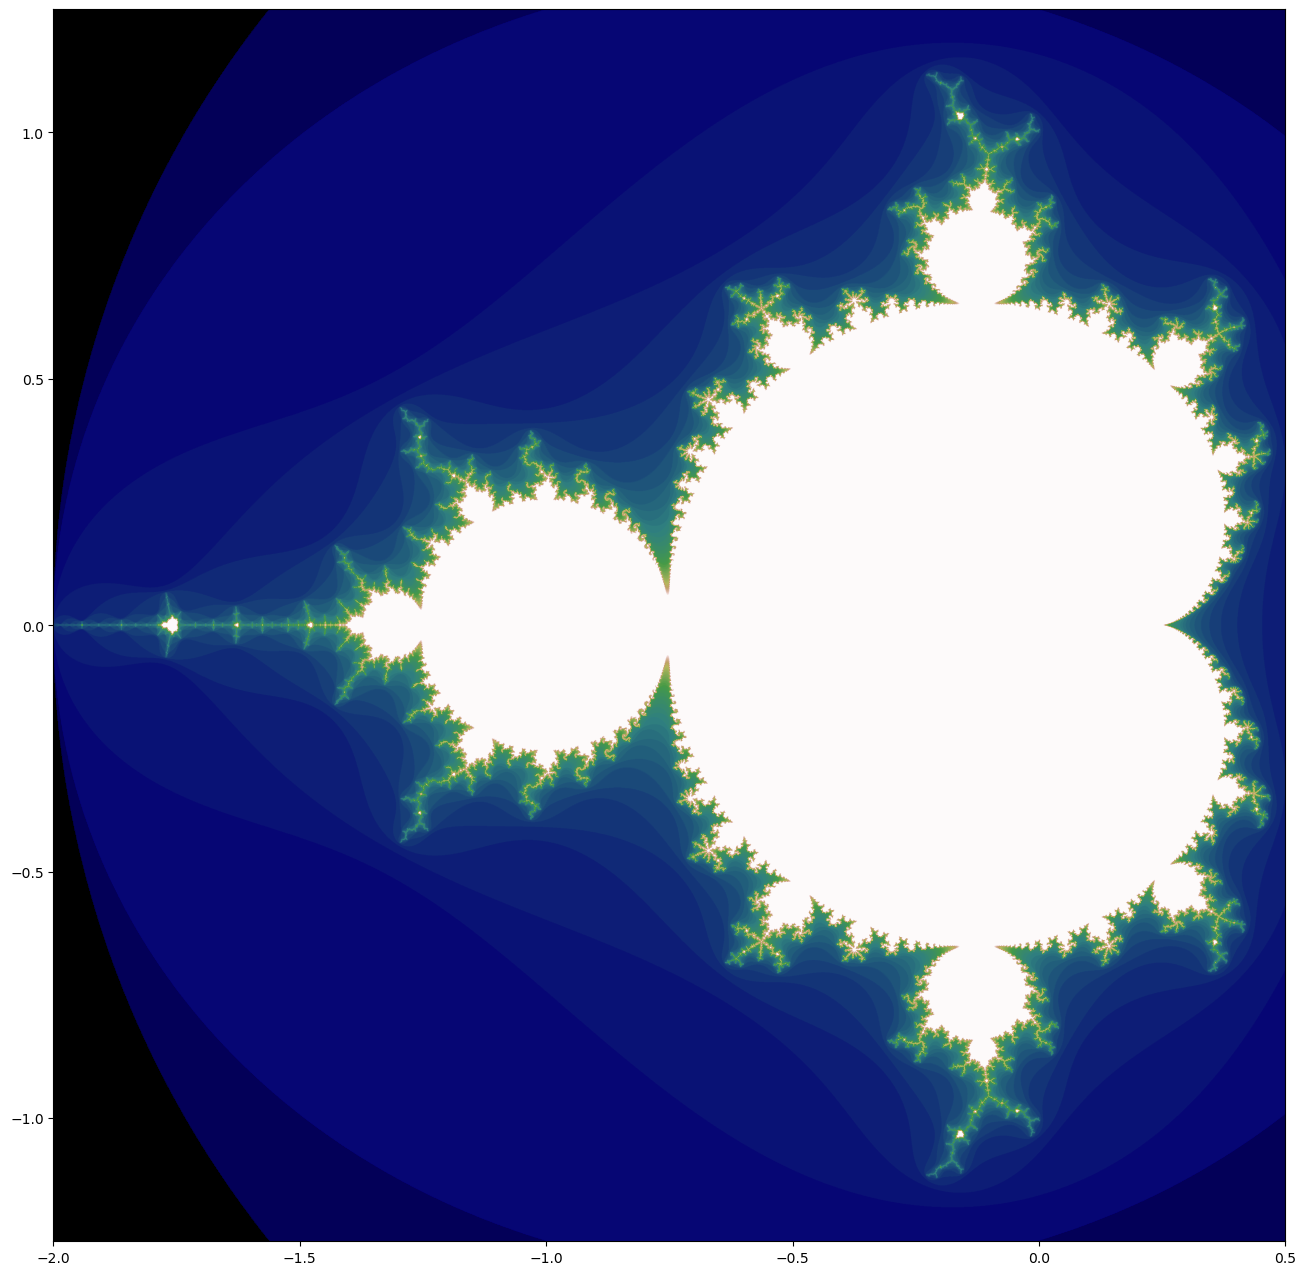

In [9]:
make_plot(M, cmap='gist_earth')

## Parallel (using multiprocessing) solution

In [10]:
@jit(nopython=True)
def mandelbrot_chunk(c, I, T):
    M = np.zeros(c.shape)
    
    x_max, y_max = c.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0
            for i in range(I):
                z = z**2 + c[x, y]
                if abs(z) > T:
                    M[x, y] = i
                    break
            else:
                M[x, y] = I
    
    return M

def mandelbrot_paralell(c, I, T, P, chunk_size):
    pool = mp.Pool(processes=P)

    results = [pool.apply_async(mandelbrot_chunk, args=(c[i:i+chunk_size, :], I, T)) for i in range(0, c.shape[0], chunk_size)]

    pool.close()
    pool.join()

    return results

In [11]:
# The multiprocessing module is not compatible Jupyter Notebook
# So we need to run this code in a separate file (paralell.py)
from paralell import mandelbrot_paralell

In [12]:
P = 8
CHUNK_SIZE = 100

re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES) * 1j

c = re + im[:, np.newaxis]
M = np.zeros((X_RES, Y_RES))

time_start = time.time()
results = mandelbrot_paralell(c, I, T, P, CHUNK_SIZE)
time_delta_paralell = time.time() - time_start

M[:] = np.vstack([r.get() for r in results])

print(f'Elapsed time: {time_delta_paralell:.2f} s')

Elapsed time: 3.71 s


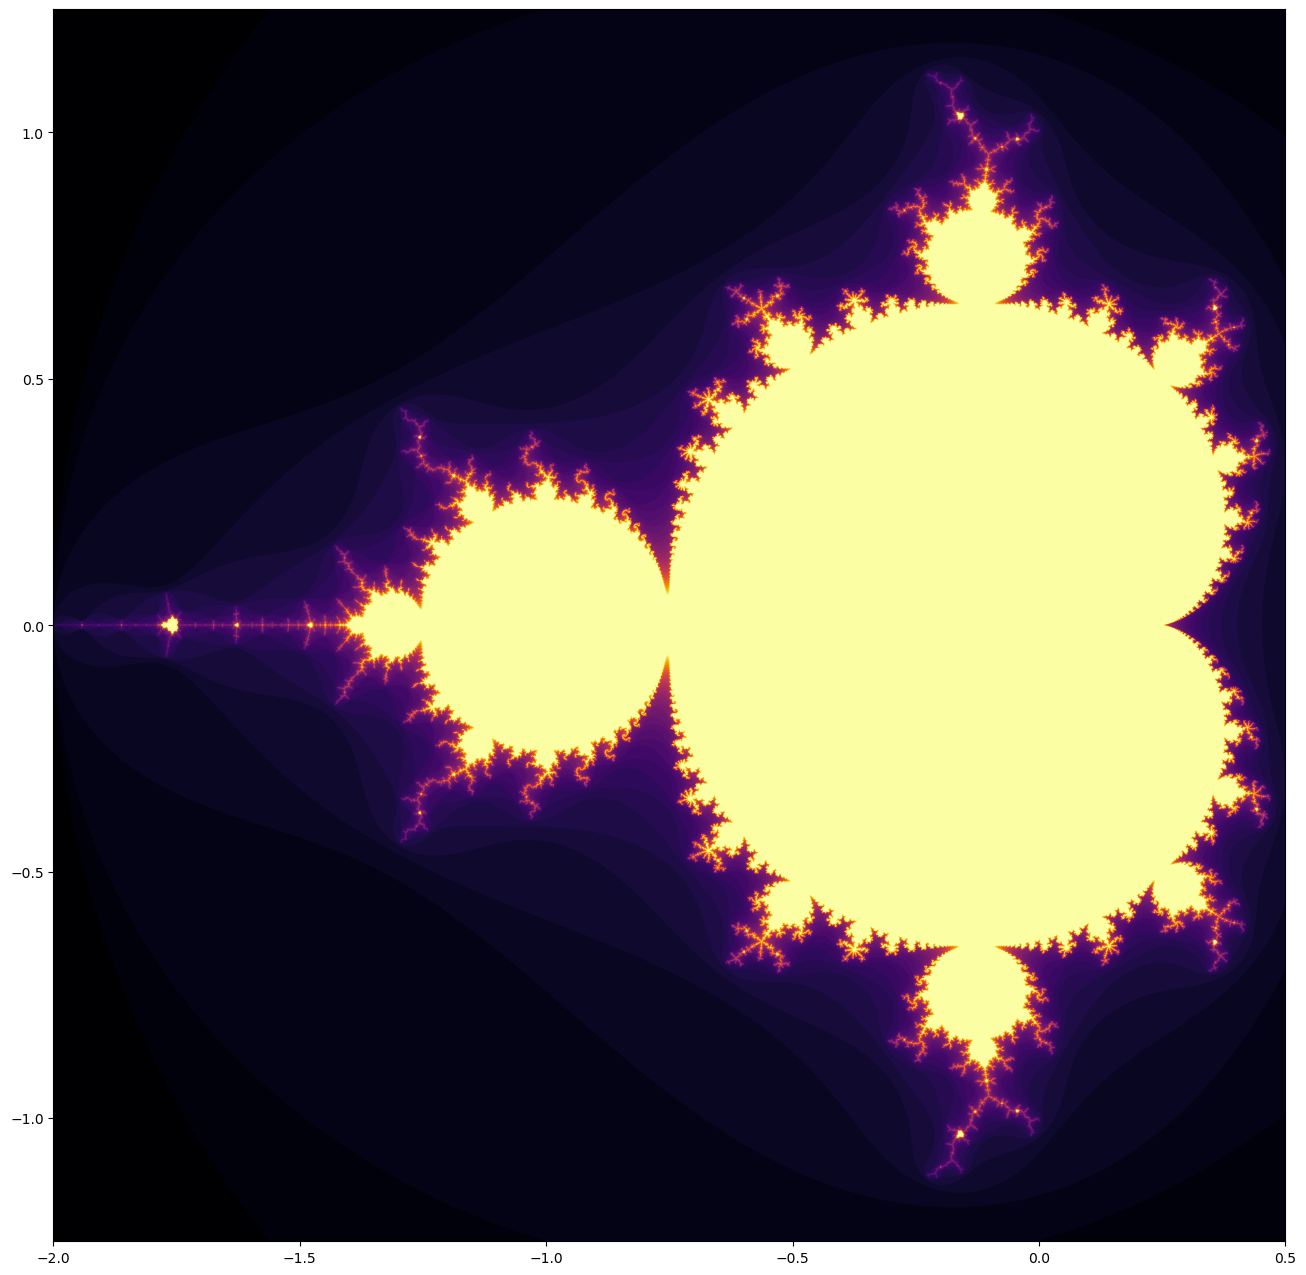

In [13]:
make_plot(M, cmap='inferno')

In [14]:
processes = np.arange(1, 13)
chunk_sizes = np.unique(np.logspace(0, 3.69, 100).astype(int))

In [15]:
times = list()

for CHUNK_SIZE in tqdm(chunk_sizes):
    for P in processes:
        re = np.linspace(X_MIN, X_MAX, X_RES)
        im = np.linspace(Y_MIN, Y_MAX, Y_RES) * 1j

        c = re + im[:, np.newaxis]
        M = np.zeros((X_RES, Y_RES))

        time_start = time.time()
        results = mandelbrot_paralell(c, I, T, P, CHUNK_SIZE)
        time_delta = time.time() - time_start
        
        times.append([P, CHUNK_SIZE, time_delta])

100%|██████████| 82/82 [2:26:41<00:00, 107.33s/it]  


In [ ]:
times_np = np.array(times)

# Save data to a csv file for later use
times_df = pd.DataFrame(times_np, columns=['P', 'chunk_sizes', 'time'])
times_df.to_csv('times.csv', index=False)

In [16]:
# Load data from a csv file
times_df = pd.read_csv('times.csv')
times_np = times_df.values

In [17]:
optimal_parameters = times_np[np.argmin(times_np[:, 2])]
print(f'Optimal parameters for prcesses is {optimal_parameters[0]:.0f} and for chunk size is {optimal_parameters[1]:.0f}.')
print(f'Elapsed time: {optimal_parameters[2]:.2f} s')

time_delta_paralell_optimal = optimal_parameters[2]

optimal_chunk_sizes = list()
for P in np.unique(times_np[:, 0]):
    times_np_p = times_np[times_np[:, 0] == P]
    optimal_chunk_sizes.append(times_np_p[np.argmin(times_np_p[:, 2])])
optimal_chunk_sizes = np.array(optimal_chunk_sizes)

# Convert to log scale for better visualization
# Very big numbers are hard to visualize on a linear scale
times_np_log = times_np.copy()
times_np_log[:, 2] = np.log10(times_np[:, 2])

Optimal parameters for prcesses is 3 and for chunk size is 6.
Elapsed time: 1.67 s


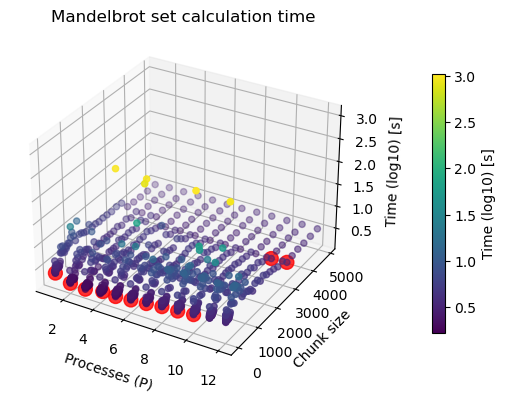

In [18]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ax.scatter(
    xs=times_np_log[:, 0],
    ys=times_np_log[:, 1],
    zs=times_np_log[:, 2],
    c=times_np_log[:, 2],
    cmap='viridis')

ax.scatter(
    xs=optimal_chunk_sizes[:, 0],
    ys=optimal_chunk_sizes[:, 1],
    zs=np.log10(optimal_chunk_sizes[:, 2]),
    c='red',
    s=100,
    alpha=0.8)

ax.set_xlabel('Processes (P)')
ax.set_ylabel('Chunk size')
ax.set_zlabel('Time (log10) [s]')

ax.set_title('Mandelbrot set calculation time')

fig.colorbar(colors, ax=ax, shrink=0.7, pad=0.15, label='Time (log10) [s]')

plt.show()

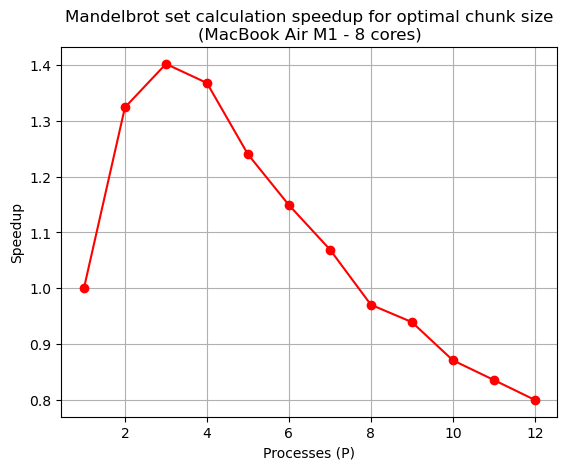

In [19]:
signal_process_time = optimal_chunk_sizes[0, 2]
speedup = signal_process_time / optimal_chunk_sizes[:, 2]

fig = plt.figure()
ax = fig.add_subplot()

plt.plot(processes, speedup, 'o-', c='red', label='Speedup')

plt.xlabel('Processes (P)')
plt.ylabel('Speedup')
plt.title('Mandelbrot set calculation speedup for optimal chunk size\n(MacBook Air M1 - 8 cores)')
plt.grid()

plt.show()

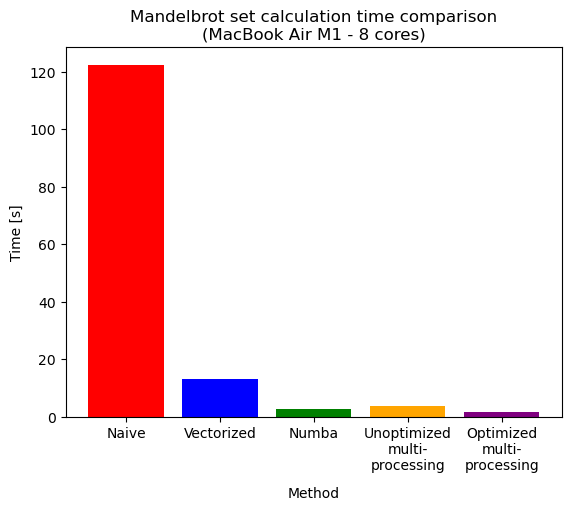

In [20]:
method_names = ['Naive', 'Vectorized', 'Numba', 'Unoptimized\nmulti-\nprocessing', 'Optimized\nmulti-\nprocessing']
method_times = [time_delta_naive, time_delta_vectorized, time_delta_numba, time_delta_paralell, time_delta_paralell_optimal]

fig = plt.figure()

ax = fig.add_subplot()

ax.bar(method_names, method_times, color=['red', 'blue', 'green', 'orange', 'purple'])

plt.xlabel('Method', labelpad=10)
plt.ylabel('Time [s]')
plt.title('Mandelbrot set calculation time comparison\n(MacBook Air M1 - 8 cores)')

plt.show()